In [1]:
from Scripts.mklib import cell_width
cell_width(140)

### Capstone - StarCraft II<br>by Mycchaka Kleinbort

<right><img src="./Images/AI_timeline.png" style=" margin: 5px; width: 1080px"></right>

It is perhaps inevitable that any game played by humans will eventually become the subject of ongoing A.I. research. The framework of games - rules and objectives - is inherently suited to systematic study, and their ever increasing complexity has motivated a seemingly endless stream of new tools and insights.

In November of 2016 Google DeepMind - in partnership with Blizzard entertainment - announced their intention to make Starcraft 2 the focus of further A.I. research. In this project we seek to compile and explore the currently available data, to extract and infer features that can qualify a player's performance, and to validate these features by building several predictive models.

[](#objectives)
## Objectives

>The game lasted for 73 moves but eventually Deep Blue's operator had to resign the game for the computer in a position where both players had a bishop but Kasparov had three pawns to Deep Blue's one.
<br>
><div style="color:gray ; text-align: left">_Kasparov vs Deep Blue - Game 2, 1996_</div>

At low skill levels players often go through the motions of torching every house and eliminating every larva till the game engine grants them victory. However, much like in chess, experienced players know when it's over and concede the match. 

This ability to distinguish between a difficult situation and a hopeless one is a prerequisite of expert play, and as of yet utterly beyond the capabilities of the game's AI. We hope that through exploring this aspect of the game, several interesting metrics for a player's performance will come to light.

### Principal objective

Our main goal is to build a predictive model that can predict a player's eventual surrender based on the game's current state. Formally this will be a classification model that will take as input the game state and predict for each player whether they will eventually surrender or win the game.

Intuition tells us that this model will be capable of predicting the winner with increasing certainty and accuracy as the game progresses. Hopefully, analyzing the model's predictions will allow us to perceive:

   - games where a player's advantage is becoming ever more entrenched.
   - games where the player manages to overcome a difficult situation.
   - games where the odds of each player change dramatically due to one battle or decision. 
   
### Preliminary objective

Our task above has a very clear 'simplest case': 

    To predict who surrendered at the moment the game ended.

Our first efforts are directed towards attaining a highly accurate model capable of predicting who was the winner given the final game state.


The interested reader can take a look at the game linked below and attempt to predict the winner as early as possible.

In [2]:
from IPython.display import HTML
# Youtube: A Terran vs Zerg game
HTML("""<iframe width="854" height="480" 
     src="https://www.youtube.com/embed/Yjj7QFV62p0?rel=0&amp;controls=1&amp;showinfo=0" 
     frameborder="0" allowfullscreen></iframe>""")

### Scope

We restrict our attention exclusively to:
   - 1v1 games
   - played under the latest major update to the game (LotV)
   - in maps that have been part of the ladder rotation
   - and with the default competitive ruleset.

### Technical challenges resolved in other notebooks

##### Sourcing the data:
With approximately 100,000 StarCraft II games played daily, replay files are a dime a dozen. We sourced several hundred replay files through web scraping.

The process was relatively straight forward, but details can be found in the sister notebook:

> Appendix 2. Sourcing Data.ipynb

##### The replay file format:
A significant issue we faced was dealing with the unstructured data of replay files. 

It is not particularly important for the reader to be familiar with Blizzard's proprietary format, but it is worth noting that:

   - The replay files are a hexadecimal representation of human actions during the game. Due to the deterministic nature of StarCraft II this is all that is required for the game engine to produce a facsimilie of the match.
   - We made use of sc2reader - an open source python library - to parse a replay files into a python object.
   - We munged the information of the parsed files into elementary python objects improving loading times by 99.8%, ram consumption by 99%, and disk space by 50%. Details of our work in this area can be found in the sister notebook:

> Appendix 1. Converting replays to dictionaries.ipynb
    

## SECTION 1: Data Retrieval

We start with exploring the dictionary represetation of a replay file. We load the previously processed 422 games of the IEM Season XI - World Championship that took place in early 2017.

In [3]:
import pickle
with open('./../../../sc2games/PickledGames/iem_replays.p','rb') as corpus:
    iem_games = pickle.load(corpus)
    
example_game = iem_games[0]

In [4]:
example_game.keys()

dict_keys(['context', 'objects', 'player_stats', 'unit_positions', 'upgrades', 'object_keys', 'player_stat_keys'])

A pre-processed replay contains five sets of information: the objects, player stats, upgrade data, position data and context. Respectively, these encode:

##### Objects
All units, buildings, mineral deposits or other player-interactable objects that occured throughout the match. These are indexed by their unique id (internal to the game of which they were part) and contain information such as their time of creation, their time of death, what player controlled them, and other features that can't be looked up in a reference table.

##### Player stats
The game keeps track of several player statistics at 10 second intervals throughout the match. Several of these metrics for player performance may be deduced from the object data (such as total army value), but others (such as resource collection rate or upgrades in progress) are only available here. The player stats section of the pre-processed replay file contains the information that can't be deduced.

##### Upgrade data
The original replay files contained a log of evets, some of which indicated that a player had completed an upgrade. Here we stored the upgrade obtained, the player who obtained it, and the time at which this happened.

##### Position data
The original replay file has a somewhat eclectic behaviour with regards to unit position tracking. In addition to the locations at the end of the game (or where the unit died) the game also logs - every 15 secods - the location of units that took damage within the last 15 seconds. Accurate unit tracking is a task performed by the game engine.

Due to data quality issues, we will not include this data in our initial modeling.

##### Context
This is the metadata obtained through sc2reader. It includes the date of the game, the map, the player names, the version of the game, the ruleset used, the time zone, location of the game server that hosted the match, etc. Our main use of this information is to verify that a game falls within the scope of this project (1v1 games played with the standard ruleset, on standard maps, since the most recent major change to the game).

We convert this data to dataframes and perform some basic data cleaning.

### Units

In [5]:
import pandas as pd

# Parsing unit data to dataframe
def parse_unit_data(replay_dict):
        df_units = pd.DataFrame(data = replay_dict['objects']).T
        df_units.columns = columns=replay_dict['object_keys']
        return df_units

In [6]:
example_units = parse_unit_data(example_game)
example_units.sample(5, random_state=2)

,died_at,finished_at,hallucinated,id,killed_by,killed_units,killing_player,killing_unit,location,name,owner,race,started_at
82575362,6572,6540,False,82575362,2,[],2,68419585,"(66, 157)",KD8Charge,2,Neutral,6540
141033474,17509,15976,False,141033474,1,[133693444],1,143654917,"(88, 144)",Marine,2,Terran,15976
22806530,13834,12370,False,22806530,2,[126877697],2,125829122,"(94, 150)",Marine,1,Terran,12370
67633155,4225,4193,False,67633155,2,[],2,68419585,"(70, 157)",KD8Charge,2,Neutral,4193
3407874,17110,14558,False,3407874,1,[],1,79953930,"(67, 152)",Marine,2,Terran,14558


> Note that the unit of time is 'frames', the number of 16ths of a second since the game started.

We will make the unit names lower case and unzip the location touples.

In [7]:
def clean_unit_data(df_units):
    df_units['x'], df_units['y'] = zip(*df_units['location'].values)
    df_units = df_units.drop(['location'], axis=1)
    df_units['name'] = df_units['name'].apply(lambda x:x.lower())
    return df_units

In [8]:
example_clean_units = clean_unit_data(example_units)
example_clean_units.sample(5, random_state=2)

,died_at,finished_at,hallucinated,id,killed_by,killed_units,killing_player,killing_unit,name,owner,race,started_at,x,y
82575362,6572,6540,False,82575362,2,[],2,68419585,kd8charge,2,Neutral,6540,66,157
141033474,17509,15976,False,141033474,1,[133693444],1,143654917,marine,2,Terran,15976,88,144
22806530,13834,12370,False,22806530,2,[126877697],2,125829122,marine,1,Terran,12370,94,150
67633155,4225,4193,False,67633155,2,[],2,68419585,kd8charge,2,Neutral,4193,70,157
3407874,17110,14558,False,3407874,1,[],1,79953930,marine,2,Terran,14558,67,152


### Player Stats

In [9]:
# Parsing player stats data into dataframe
def parse_stats_data(replay_dict):
    df_stats = pd.DataFrame(data = replay_dict['player_stats'])
    df_stats.columns = columns=replay_dict['player_stat_keys']
    return df_stats

In [10]:
example_stats = parse_stats_data(example_game)

# We display the transpose for readibility
example_stats.head(15).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
frame,17280,160,4800,11360,160,4800,11360,2400,12800,12800,15520,2400,7680,15520,7680
minerals_collection_rate,2351,335,1399,3219,251,1231,1987,867,2687,1875,1987,839,1791,2099,1623
minerals_current,388,40,105,50,30,240,68,75,735,188,143,50,165,463,68
minerals_used_in_progress_army,1000,0,250,400,0,100,550,50,600,600,950,50,500,850,200
minerals_used_in_progress_economy,0,50,200,0,50,100,400,550,100,150,0,550,500,0,100
minerals_used_in_progress_technology,0,0,0,575,0,0,0,0,400,275,0,0,300,150,425
pid,1,1,1,1,2,2,2,1,1,2,1,2,1,2,2
vespene_collection_rate,985,0,313,1007,0,313,649,179,940,627,1007,156,649,627,358
vespene_current,589,0,120,68,0,195,528,98,112,928,409,98,196,994,194
vespene_used_in_progress_army,275,0,100,325,0,0,325,50,325,200,250,50,275,275,125


### Upgrades

In [11]:
# Parsing unpgrade data to dataframe
def parse_upgrade_data(replay_dict):
    df_upgrades = pd.DataFrame(replay_dict['upgrades'])
    return df_upgrades

In [12]:
example_upgrades = parse_upgrade_data(example_game)
example_upgrades.sample(5, random_state=2)

,frame,pid,second,upgrade_type_name
1,10277,2,642,ShieldWall
0,2317,2,144,SprayTerran
14,0,1,0,SprayTerran
9,14796,1,924,TerranInfantryWeaponsLevel2
19,16508,2,1031,TerranInfantryArmorsLevel2


This revealed a curious eccentricity of the game - cosmetic decorations, dance emotes and other superfluous information is logged as upgrades. We drop that information.

In [13]:
def clean_upgrade_data(df_upgrades):
    return df_upgrades[['SprayTerran' not in x and 'Reward' not in x for x in df_upgrades['upgrade_type_name']]]

In [14]:
example_upgrades_clean = clean_upgrade_data(example_upgrades)
example_upgrades_clean.sample(5, random_state=2)

,frame,pid,second,upgrade_type_name
22,10479,2,654,TerranInfantryWeaponsLevel1
11,14798,1,924,TerranInfantryArmorsLevel2
13,16180,2,1011,TerranVehicleWeaponsLevel1
1,10277,2,642,ShieldWall
19,16508,2,1031,TerranInfantryArmorsLevel2


## Context

We take a look at the metadata associated to our example game.

In [15]:
pd.Series(example_game['context'])

build                                                         49957
category                                                    Private
date                                            2017-03-04 11:33:31
file_time                                                      None
filehash          360f14af4958e8b31ffe210e59696cfe2cbc10e1d1f463...
filename          ./../../../sc2games/IEM XI - World Championshi...
frames                                                        17624
game_fps                                                         16
game_length                                                     786
is_ladder                                                     False
is_private                                                     True
map_name                                    Cactus Valley LE (Void)
observers         [{'name': 'CasterOne', 'pid': 3, 'messages': [...
players           [{'avg_apm': None, 'color': {'r': 180, 'g': 20...
real_length                                     

Much of this information will be used for checking the data quality of the replay file, and that it falls within the scope of our project. Of note is the terrible labeling of the game type by sc2reader. We've encountered games with 

    type = '1v1'
    real_type = 1
    len(players) = 6
    
We consider a game to be a true '1v1' if the list of players has a length of exactly two.

The most important part of the context information is the outcome of the game. This can be retrieved by looking at the player data.

In [16]:
# player 1
example_game['context']['players'][0]

{'avg_apm': None,
 'color': {'a': 255, 'b': 30, 'g': 20, 'name': 'Red', 'r': 180},
 'handicap': 100,
 'messages': [],
 'name': 'INnoVation',
 'pick_race': 'Terran',
 'pid': 1,
 'play_race': 'Terran',
 'result': 'Win',
 'type': None,
 'uid': 4,
 'url': 'http://xx.battle.net/sc2/en/profile/523/1/INnoVation/'}

In [17]:
# Parse the game metadata for the outcome for players 1 and 2
def parse_outcome_data(replay_dict):
    outcome = {player['result']:player['pid'] for player in replay_dict['context']['players']}
    return outcome

In [18]:
parse_outcome_data(example_game)

{'Loss': 2, 'Win': 1}

### Preliminary processing 
We can combine these preliminary data cleaning steps into a dictionary.

In [19]:
def preliminary_processing(replay_dict):
    dict_of_dataframes = {'units': clean_unit_data(parse_unit_data(replay_dict)),
                          'stats': parse_stats_data(replay_dict),
                          'upgrades': clean_upgrade_data(parse_upgrade_data(replay_dict)),
                          'context': replay_dict['context'],
                          'outcome':parse_outcome_data(replay_dict)}
    return dict_of_dataframes

In [20]:
example_parsed_game = preliminary_processing(example_game)

## Section 2: Munging the data to a 1-d array.
These tables all describe a single game, but our intention is to analyse a corpus of games. To this end, the state of a single game needs to be represented as a 1-d numeric array. In this section we represent the final state of the game as a pandas series.

Throughout our feature extraction we will abide by the following convention when naming our features.

    The first character corresponds to the player to which this feature relates
        (features that relate to both players equally start with an alphanumeric character)
       
    The second letter encodes the source of this feature.
        S - stats data
        U - upgrade data
        C - clustering data
        T,Z,P - unit tally data for Terran, Zerg and Protoss units

### Player stats data
Converting player stats data to a series is straightforward. We simply need to find the last update to each player's stats, alter the feature names to encode the player they refer to, and concatenate this information for both players.

In [21]:
def get_stats_end(dict_of_dataframes):
    """returns a series with the stats 
    for each player at the end of the game"""
    df = dict_of_dataframes['stats'].sort_values(by='frame').tail(3)
    
    p1 = df[df['pid']==1].tail(1).to_dict()
    p2 = df[df['pid']==2].tail(1).to_dict()

    # We use the prefix S to specify that a specific feature is stats data.
    p1 = {'1'+'S_'+key:list(p1[key].values())[0] for key in p1.keys()}
    p2 = {'2'+'S_'+key:list(p2[key].values())[0] for key in p2.keys()}

    return pd.Series({**p1,**p2}).drop(['1S_frame','2S_frame','1S_pid','2S_pid'])

In [22]:
get_stats_end(example_parsed_game)

1S_minerals_collection_rate                2351
1S_minerals_current                          63
1S_minerals_used_in_progress_army          1150
1S_minerals_used_in_progress_economy          0
1S_minerals_used_in_progress_technology       0
1S_vespene_collection_rate                  985
1S_vespene_current                          555
1S_vespene_used_in_progress_army            400
1S_vespene_used_in_progress_economy           0
1S_vespene_used_in_progress_technology        0
2S_minerals_collection_rate                1595
2S_minerals_current                         118
2S_minerals_used_in_progress_army           400
2S_minerals_used_in_progress_economy          0
2S_minerals_used_in_progress_technology       0
2S_vespene_collection_rate                  627
2S_vespene_current                         1144
2S_vespene_used_in_progress_army              0
2S_vespene_used_in_progress_economy           0
2S_vespene_used_in_progress_technology        0
dtype: int64

Note that we have dropped several key pieces of information, such as the total army mineral value, total army size or number of workers. They were present in the original set of player stats data parsed by sc2reader, but they can - in principle - be deduced as linear combinations of the units alive at a given time.

### Upgrade data
Once an upgrade is unlocked it remains unlocked permanently. Therefore, finding the upgrades in play at the end of the game is simply the sum across time of all upgrades unlocked (grouped by player).

In [23]:
def get_upgrades_end_part_1(dict_of_dataframes):
    if dict_of_dataframes['upgrades'].shape[0] == 0:
        upgrades = None
    else:
        upgrades = dict_of_dataframes['upgrades'].drop(['frame','second'], axis=1)\
                .groupby('pid')\
                .apply(lambda x: pd.get_dummies(x, prefix=[str(x['pid'].iloc[0])+'U']))\
                .drop(['pid'], axis=1)\
                .sum()
                
    return upgrades

In [24]:
get_upgrades_end_part_1(example_parsed_game)

1U_ShieldWall                     1.0
1U_Stimpack                       1.0
1U_TerranInfantryArmorsLevel1     1.0
1U_TerranInfantryArmorsLevel2     1.0
1U_TerranInfantryWeaponsLevel1    1.0
1U_TerranInfantryWeaponsLevel2    1.0
1U_TerranVehicleWeaponsLevel1     1.0
2U_ShieldWall                     1.0
2U_Stimpack                       1.0
2U_TerranInfantryArmorsLevel1     1.0
2U_TerranInfantryArmorsLevel2     1.0
2U_TerranInfantryWeaponsLevel1    1.0
2U_TerranInfantryWeaponsLevel2    1.0
2U_TerranVehicleWeaponsLevel1     1.0
dtype: float64

This is exacly what we hoped for. 

Note that each upgrade may be obtained only once by each player, and that only the upgrades that were obtained (and not all possible upgrades) are showing up - hence the value of 1 for each upgrade. 

Some upgrades are tiered, with higher tier ones only obtainable where a lower tier one has been unlocked. For example, player 1 had to unlock TerranInfantryArmorsLevel1 before researching TerranInfantryArmorsLevel2, and TerranInfantryWeaponsLevel1 before TerranInfantryWeaponsLevel2.

For these upgrades, a better representation would be the upgrade name followed by the tier unlocked.

In [25]:
def get_upgrades_end_part_2(upgrades):
    if upgrades is None:
        return None
    else:
        upgrades = [name[:-1] if name[-1].isdigit() else name for name in upgrades.index]
        return pd.Series(upgrades).value_counts()

def get_upgrades_end(dict_of_dataframes):
    """returns a series with the upgrades unlocked (and their tier)
    for each player at the end of the game"""
    return get_upgrades_end_part_2(get_upgrades_end_part_1(dict_of_dataframes))

In [26]:
get_upgrades_end(example_parsed_game)

2U_TerranInfantryWeaponsLevel    2
1U_TerranInfantryArmorsLevel     2
1U_TerranInfantryWeaponsLevel    2
2U_TerranInfantryArmorsLevel     2
2U_ShieldWall                    1
2U_TerranVehicleWeaponsLevel     1
1U_TerranVehicleWeaponsLevel     1
1U_Stimpack                      1
2U_Stimpack                      1
1U_ShieldWall                    1
dtype: int64

### Units

The units in play are our main source of data, but turning the information they contain into a one dimentional array is also our main challenge.

##### Bag of units
We can take a page from NLP and consider a "bag of units" tokenization of the units at play. This is effectively a tally of the various unit types alive when the game ended, segregated by player.

This data can then be used in combination with a lookup table to give us metrics such as total army size, total army value, number of workers, number of bases, etc. 

This can also be used to consider the significance of having air superiority, invisible units, many cheap units or a few high quality ones. All these aggregations could result in interesting features.

Alternatively, the tallies of units may be fed into an unregularized linear model that will implicitly consider these linear combinations.

In [27]:
def get_unit_tally_end(dict_of_dataframes):
        """returns a series with tallies of units 
        for each player at the end of the game"""
        df = dict_of_dataframes['units']
        
        # We select the units that never died, belonnging to either player
        df = df[df['died_at'].apply(lambda x: isinstance(x, type(None)))]
        df = df[df['race']!= 'Neutral']
 
        # We prefix the unit names with the player id, and unit race initial (T,Z or P)
        tally = df[['owner','race','name']]\
                 .apply(lambda x: str(x['owner'])+x['race'][0]+'_'+ x['name'], axis=1)\
                 .value_counts()
        return tally

In [28]:
example_unit_tally = get_unit_tally_end(example_parsed_game)
example_unit_tally.head(5)

1T_scv            68
2T_scv            59
1T_marine         34
1T_supplydepot    13
1T_medivac        12
dtype: int64

However, sadly, this throws away our most interesting and defining data source: the position of units. 

Our next task is to convert the spatial arrangement of units to a 1-d array.

##### Analysis of unit positions

In [29]:
def get_end_location_of_units(dict_of_dataframes):
    units = dict_of_dataframes['units']
    units = units[(units['died_at'].apply(lambda x: isinstance(x,type(None)))) 
                  & (units['race'] != 'Neutral')][['name','x','y','owner']]
    return units

example_unit_locations_end = get_end_location_of_units(example_parsed_game)
example_unit_locations_end.head()

,name,x,y,owner
2359299,siegetank,91,146,1
5767171,siegetank,84,148,1
8388611,marine,163,147,1
9961474,marine,153,152,1
11796482,scv,36,157,2


Consider the location of units at the end of the first 16 games of our IEM replay corpus.

In [30]:
import matplotlib.pyplot as plt

def plot_game_end_states(games):
    '''given a corpus of replay files it will plot 
    the end location of units for the first 16 games'''
    games = games[0:min(16, len(games))]
    games = [preliminary_processing(game) for game in games]
    plt.figure(figsize=(20,10))
    for i,game in enumerate(games):
        plt.subplot(4,4, i+1)
        units = get_end_location_of_units(game).sort_values(by='owner')
        plt.scatter(units['x'], units['y'], c=units['owner'], alpha = 0.4)
        plt.title('Game {}: '.format(str(i))+['Purple','Yellow'][game['outcome']['Win']-1] + ' Won')
    plt.tight_layout(pad=1)
    plt.show()

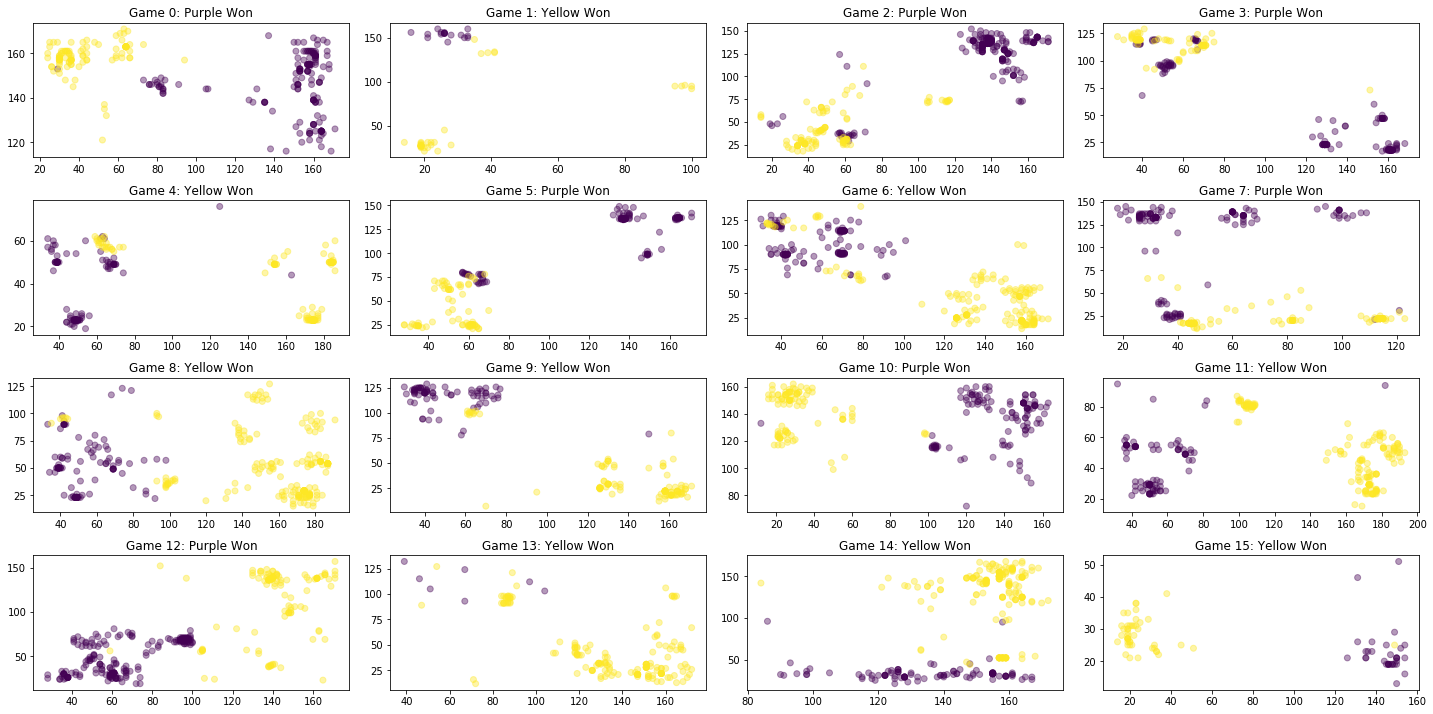

In [31]:
plot_game_end_states(iem_games)

Even without knowledge of the game or of the units represented it is sometimes possible to understand what is going on. It seems to us that in games 3,4,5,6 and 9 the winning player's army has formed a death ball that is overunning the opponent's base, and in games 2,6 and 8 the losing player seems to be overwhelmed by a two pronged attack from the winner.

We seek to encode the significance of this relative spatial arrangement of units as a 1-d set of features in such a way as can be aggregated across multiple games.

### A love letter to DBSCAN
We use some domain knowledge and DBSCAN's density based clustering to find "areas of interest" where player interaction is imminent. For each cluster we will look at the units each player has in the area and make some heuristic judgments as to the outcome of that situation.

Specifically we will: 
1. look at the military might of each player's army in each region
2. look at the economic value of each player's local infrastructure (buildings and workers)
3. make a heuristic judgment of the 'risk' such infrastructure is under based on the difference of power between the player's local troops.

We initialize the DBSCAN clusterer with
    
    eps = 10   and    min_samples = 5
    
These parameters are based on the range at which units can inflict damage

- The Terran marine has a range of 5
- Tanks a range of between 7 and 13
- Tempests have the longest range in the game at 15 

and we've set the minimal size of buildings/units needed to form a cluster to be 5 because there is hardly any situation in which a group smaller than that represents a credible threat or irrecoverable loss.

In [43]:
from sklearn.cluster import DBSCAN

unit_clusterer = DBSCAN(eps=10,min_samples=5)

def plot_units_and_clusters(units, predicted_clusters, game_id = 6):
    plt.figure(figsize=(20,10))
    plt.subplot(2,2,1)
    plt.scatter(units['x'], units['y'], c=units['owner'], alpha = 0.4, s = 50)
    plt.title('Game {}: End state'.format(game_id))

    plt.subplot(2,2,2)
    plt.scatter(units['x'], units['y'], c=predicted_clusters, alpha = 0.4, s = 50)
    plt.title('Game {}: Clusters'.format(game_id))

    plt.show()
    

We exemplify our analysis by referencing game 6 in our corpus.

This is a Zerg (player 1 - purple) vs Protoss (player 2 - yellow) played on the Abyssal Reef map.

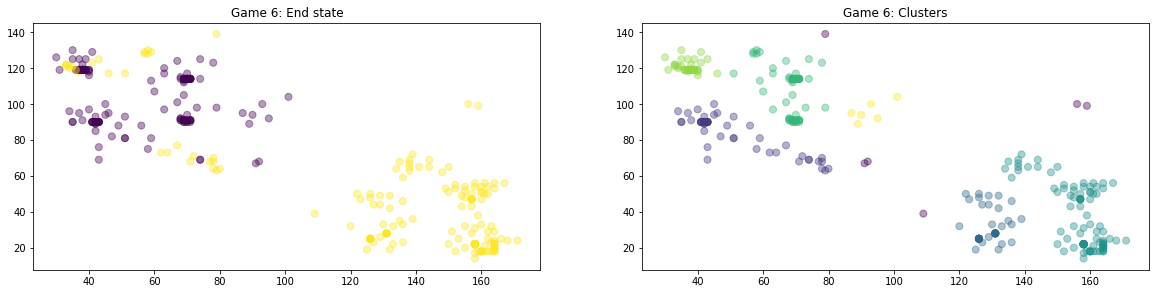

In [44]:
example_units_game_6 = get_end_location_of_units(preliminary_processing(iem_games[6]))
predicted_clusters = unit_clusterer.fit_predict(example_units_game_6[['x','y']])

plot_units_and_clusters(example_units_game_6,predicted_clusters,game_id=6)

At this point we make use of the unit names to 'look up' additional information for each unit in the plot above. 

To this end we reference the database of unit attributes (a jason) that sc2reader uses to parse the replay files. Some data munging is nessesary, but also straightforward.

In the cells that follow we import the unit information, munge it into a series indexed by the unit names and a dataframe with 'name' feature.

In [45]:
# Looking at the unit data info within sc2reader
pd.read_json('/usr/local/lib/python3.6/site-packages/sc2reader/data/unit_info.json').head()

,Protoss,Terran,Zerg
archon,"{'is_army': True, 'minerals': 175, 'vespene': ...",NaN,NaN
armory,NaN,"{'minerals': 150, 'vespene': 100, 'supply': 0,...",NaN
assimilator,"{'minerals': 75, 'vespene': 0, 'supply': 0, 'i...",NaN,NaN
baneling,NaN,NaN,"{'is_army': True, 'minerals': 50, 'vespene': 2..."
banelingburrowed,NaN,NaN,"{'is_army': True, 'minerals': 50, 'vespene': 2..."


In [46]:
# Munging unit info data into a series to facilitate key-based queries
unit_info_from_json = pd.read_json('/usr/local/lib/python3.6/site-packages/sc2reader/data/unit_info.json')\
                   .apply(lambda x:x['Protoss'] if x['Protoss'] == x['Protoss'] 
                                 else x['Terran'] if x['Terran'] == x['Terran'] else x['Zerg'], axis=1)
unit_info_from_json.head()

archon              {'is_army': True, 'minerals': 175, 'vespene': ...
armory              {'minerals': 150, 'vespene': 100, 'supply': 0,...
assimilator         {'minerals': 75, 'vespene': 0, 'supply': 0, 'i...
baneling            {'is_army': True, 'minerals': 50, 'vespene': 2...
banelingburrowed    {'is_army': True, 'minerals': 50, 'vespene': 2...
dtype: object

In [120]:
# Munging unit info data to a dataframe
unit_lookup_table = pd.DataFrame([{**unit_info_from_json[key], **{'name':key}} 
                                  for key in unit_info_from_json.keys()]).fillna(False)

unit_lookup_table.head()

,is_army,is_building,is_worker,minerals,name,supply,vespene
0,True,False,False,175,archon,4.0,275
1,False,True,False,150,armory,0.0,100
2,False,True,False,75,assimilator,0.0,0
3,True,False,False,50,baneling,0.5,25
4,True,False,False,50,banelingburrowed,0.5,25


We can now perform a left merge on the unit name with our units at the end of game 6.

In [121]:
unit_details = pd.merge(example_units_game_6, unit_lookup_table, on='name', how='left')
unit_details['predicted_cluster'] = predicted_clusters
unit_details.head()

,name,x,y,owner,is_army,is_building,is_worker,minerals,supply,vespene,predicted_cluster
0,drone,41,90,1,False,False,True,50,1.0,0,0
1,assimilator,132,42,2,False,True,False,75,0.0,0,1
2,fleetbeacon,152,18,2,False,True,False,300,0.0,200,2
3,creeptumorburrowed,101,104,1,False,True,False,0,0.0,0,5
4,hightemplar,160,51,2,True,False,False,50,2.0,150,2


We used Tableau to visualize this data. If the embedded Tableau dashboard doesn't show up on github the reader can find it [here](https://dub01.online.tableau.com/t/mkleinbortatgmailcom/views/Sc2plots-h/Dashboardhorizontal?:embed=y&:loadOrderID=21&:display_spinner=no&:showAppBanner=false&:showShareOptions=true&:display_count=no&:showVizHome=no).

In [122]:
HTML("""
<script type='text/javascript' src='https://dub01.online.tableau.com/javascripts/api/viz_v1.js'>
</script><div class='tableauPlaceholder' style='width: 1084px; height: 396px;'>
<object class='tableauViz' width='1084' height='396' style='display:none;'>
<param name='host_url' value='https%3A%2F%2Fdub01.online.tableau.com%2F' />
<param name='site_root' value='&#47;t&#47;mkleinbortatgmailcom' />
<param name='name' value='Sc2plots-h&#47;Dashboardhorizontal' />
<param name='tabs' value='no' /><param name='toolbar' value='yes' />
<param name='showAppBanner' value='false' />
<param name='showShareOptions' value='true' />
</object></div>""")

### Converting clusters into features

Due to our intention of representing the end state of a game as a 1-d array, we must convert the spatial unit information to this form. It would also be desirable that the length of this array be game-independent to facilitate the comparison across games.

Our approach is to evaluate 3 metrics for each cluster (for each player) - and to aggregate these metrics across all clusters. The 3 metrics under consideration are local military power, local military value, and local economic value.

Assessing military power in an accurate way is virtually impossible, but we will use 'supply' cost as the measurement of a unit's military power. Blizzard must ensure that if both players reach the maximum army size of 200 supply then the game is still as balanced as possible, and there have been active efforts by their developers to update the game so as to keep the unit-power/supply ratio balanced.

However, in this metric 400 zerglings at 1/2 supply each should be considered roughly as powerful as 33 battlecruisers at 6 supply each. The fact that battlecruisers are a flying unit and zerglings have no way of inflicting damage on them is utterly beyond the resolution provided by this crude metric.

We measure the value of a group of units simply as the weighted sum of the mineral and vespene cost of all its components. Note that vespene is much harder to obtain than minerals, with mineral collection rates usually being more than double those of vespene. Hence we use

    value = Mineral cost + 2*Vespene cost
    

In [123]:
def assess_cluster(units_in_cluster):
    """This function takes the units in a cluster, and returns a 2x3 dataframe 
    that contains the local military power of each player, the army value, 
    and the economic value of the non-army units in the cluster"""
    
    # We tally the units of each type within the cluster grouped by owner
    x = pd.DataFrame(units_in_cluster.groupby('owner')['name'].value_counts())
    
    # We query the information of relevance for each unit type
    x['supply'] = [unit_info_from_json[name[1]].get('supply',0) for name in x.index]
    x['is_army'] = [unit_info_from_json[name[1]].get('is_army', False) for name in x.index]
    x['is_worker'] = [unit_info_from_json[name[1]].get('is_worker', False) for name in x.index]
    x['minerals'] = [unit_info_from_json[name[1]].get('minerals', 0) for name in x.index]
    x['vespene'] = [unit_info_from_json[name[1]].get('vespene', 0) for name in x.index]
    
    # Assessing military power
    x['military_power'] = x.apply(lambda x: x['is_army']*x['supply']*x['name'], axis = 1)
    
    # Assessing local army value 
    x['military_value'] = x.apply(lambda x: ((x['minerals']/50)+(x['vespene']/25))*x['name'] if x['is_army'] else 0, axis = 1)

    # We measure economic value as simply the weighted sum of the mineral and vespene cost of all non-army units in the area.
    x['economy_value'] = x.apply(lambda x: ((x['minerals']/50)+(x['vespene']/25))*x['name'] if not x['is_army'] else 0, axis = 1)
                                 
    x = x.groupby('owner')[['military_power','military_value','economy_value']].sum()
    x.index.name = None
    
    # In case a cluster contains only units for one player
    # we guarantee that the result is of the correct form.
    for i in {1,2} - set(x.index):
        x = pd.concat([x.T,pd.Series({'military_power':0,'military_value':0,'economy_value':0}, name=i)], axis=1).T
    return x

In [124]:
units_in_cluster_0 = example_units_game_6[predicted_clusters==0]
assess_cluster(units_in_cluster_0)

,military_power,military_value,economy_value
1,5.5,28.5,46.0
2,47.0,124.5,0.0


Our heuristic reasoning to assess the probable outcome of a cluster is as follows:

1. Following Lanchester's laws for calculating the relative strengths of a predator–prey pair, the damage done to each side is proportional to the difference in the square of their numbers. 
>With firearms engaging each other directly with aimed shooting from a distance, they can attack multiple targets and can receive fire from multiple directions. The rate of attrition now depends only on the number of weapons shooting. Lanchester determined that the power of such a force is proportional not to the number of units it has, but to the square of the number of units. This is known as Lanchester's square law.

2. If the expected military casualties of one side are greater than their total military presence in the region then we deem that side's local economy to be at extreme risk, and the other team's to be safe. Doing the maths reveals that this is the case precisely when the square of one army's might is at least double that of the other team's might squared.

$$\sqrt{B^2 - A^2} \geq A \Rightarrow B^2 \geq 2(A^2) \Rightarrow \frac{B^2}{A^2} \geq 2 $$


4. Else, if the expected military casualties of one side are more than half their total military presence in the region then we deem that side's local economy to be at high risk, and the other team's to be at low risk.

$$\sqrt{B^2 - A^2} \geq \frac{1}{2}A \Rightarrow B^2 \geq \frac{5}{4}(A^2) \Rightarrow \frac{B^2}{A^2} \geq 1.25 $$


5. If neither side expects casualties greater than half their local army, then both team's local economies are at mid risk.

In [125]:
import numpy as np

def classify_cluster_outcome(units_in_cluster):
    x = assess_cluster(units_in_cluster)
    x['military_power^2'] = x['military_power'].apply(lambda x:x**2)
    
    # We calculate the power ratio as the ratio of the square of each army's local might.
    # We add an insignificant amount of power to both armies to avoid division by 0.
    power_ratio = (x['military_power^2'][1]+0.001)/(x['military_power^2'][2]+0.001)
    
    # Following the heuristic reasoning explained previously
    if power_ratio < 1/2:
        risk = {'1C_extreme_risk':x['economy_value'][1],
                '2C_safe':x['economy_value'][2]}
    elif power_ratio < 1/1.25:
        risk = {'1C_high_risk':x['economy_value'][1],
                '2C_low_risk':x['economy_value'][2]}
    elif power_ratio < 1.25:
        risk = {'1C_mid_risk':x['economy_value'][1],
                '2C_mid_risk':x['economy_value'][2]}
    elif power_ratio < 2:
        risk = {'1C_low_risk':x['economy_value'][1],
                '2C_high_risk':x['economy_value'][2]}
    else:
        risk = {'1C_safe':x['economy_value'][1],
                '2C_extreme_risk':x['economy_value'][2]}
        
    # We use our previous reasoning to predict the army value lost by each side:
    risk['1C_probable_casualties'] = x['military_value'][1]*0.5*(1 - np.log2(min(max(power_ratio,0.5),2)))
    risk['2C_probable_casualties'] = x['military_value'][2]*0.5*(1 + np.log2(min(max(power_ratio,0.5),2)))
        
    # We also return each military's supply count in the region
    # This will be used to create other features at a later stage
    risk['1C_military_power'] = x['military_power'][1]
    risk['2C_military_power'] = x['military_power'][2]
    
    return risk

In [126]:
classify_cluster_outcome(units_in_cluster_0)

{'1C_extreme_risk': 46.0,
 '1C_military_power': 5.5,
 '1C_probable_casualties': 28.5,
 '2C_military_power': 47.0,
 '2C_probable_casualties': 0.0,
 '2C_safe': 0.0}

Lastly, we can aggregate these features across all clusters.

In [56]:
def cluster_analysis(units, predicted_clusters):
    df =  pd.DataFrame([classify_cluster_outcome(units[predicted_clusters==j]) 
                    for j in list(set(predicted_clusters))]).sum()
    
    df['num_clusters'] = len(list(set(predicted_clusters)))
    return df

cluster_analysis(example_units_game_6, predicted_clusters)

1C_extreme_risk            96.0
1C_mid_risk                 2.5
1C_military_power          40.5
1C_probable_casualties     70.5
1C_safe                    44.0
2C_extreme_risk             0.0
2C_mid_risk                10.0
2C_military_power          95.0
2C_probable_casualties     17.5
2C_safe                   295.0
num_clusters                7.0
dtype: float64

We gather the steps we followed to extract useful features through clustering into one function.

In [57]:
def game_risk_analysis(dict_of_dataframes):
    """Input: a preliminarely processed game. Output: Features obtained through clustering"""
    unit_clusterer = DBSCAN(eps=10,min_samples=5)
    units = get_end_location_of_units(dict_of_dataframes)
    predicted_clusters = unit_clusterer.fit_predict(units[['x','y']])
    return cluster_analysis(units, predicted_clusters)

### Preserving relevant metadata

We wish to keep some attributes from the metadata of each game:

    'date', 'release','filename', 'frames', 'map_name' and 'time_zone'
    '1_name', '2_name', '1_play_race','2_play_race', '1_handicap', '2_handicap'

Not all of these features are pertinent to the project at hand, but it may be interesting to revisit this data at a later date.

In [58]:
def preserve_context(dict_of_dataframes):
    info_part1 = {key:dict_of_dataframes['context'][key] 
              for key in ['date','release','filename','frames','map_name','time_zone']}
    
    info_part2 = [{'{}_'.format(i+1)+key:dict_of_dataframes['context']['players'][i][key] 
                  for key in ['name', 'play_race','handicap']} for i in [0,1]]
    
    return pd.Series({**info_part1, **{**info_part2[0],**info_part2[1]}})

# Example
preserve_context(example_parsed_game)

1_handicap                                                   100
1_name                                                INnoVation
1_play_race                                               Terran
2_handicap                                                   100
2_name                                                     Ryung
2_play_race                                               Terran
date                                         2017-03-04 11:33:31
filename       ./../../../sc2games/IEM XI - World Championshi...
frames                                                     17624
map_name                                 Cactus Valley LE (Void)
release                                             3.10.1.49957
time_zone                                                      1
dtype: object

## Aggregating our features

We are now ready to iterate through the games in our corpus to get a dataframe in which each record represents the state of the game when it ended.

First let us recall the steps:

    -> Load Pre-processed game
    
        -> Verify that the game is a 1v1 game.
        
        -> Use preliminary_processing() to give the data a more tractable structure
           specifically we obtain data relating to units, player stats, 
           game context, unit upgrades and the game's outcome.
                
            -> Use get_stats_end() to get the 
               stats features at the end of the game.
               
            -> Use get_upgrades_end() to get the 
               upgrades each player had at the end of the game.
               
            -> Use get_unit_tally_end() to get the tally of units
               of each type that players had when the game ended.
               
            -> Use game_risk_analysis() to get the features developed 
               through the use of clustering and Lanchester's square law.
               
            -> Use preserve_context() to fetch the metadata we may wish to 
               return to at a later date.
               
            -> Remember to record the outcome data of the game as a feature.
             
            

In [59]:
def get_final_game_state(game):
    
    if len(game['context']['players']) != 2:
        return None 
    
    game = preliminary_processing(game)
    
    stats_features = get_stats_end(game)
    upgrade_features = get_upgrades_end(game)
    unit_tally_features = get_unit_tally_end(game)
    risk_features = game_risk_analysis(game)
    context_data = preserve_context(game)
    outcome = pd.Series(game['outcome'])
    
    return pd.concat([stats_features, upgrade_features, unit_tally_features,risk_features,context_data,outcome])

In [60]:
%%timeit
get_final_game_state(iem_games[6])

150 ms ± 1.82 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


As a passing remark, note that each game takes roughly ~150ms of processing to go from loading a pre-processed game to a series representation of the end state of the game. This may be moderately slow, but still acceptable, especially considering that the sc2reader takes close to 600ms to parse each game into a python object.

##### Converting our corpus of 422 games to a dataframe

First let us do a quick check for fringe cases:

In [61]:
for i, game in enumerate(iem_games):
    try:
        success = get_final_game_state(game)
    except:
        print('Unspecified error at game {}'.format(i))
        
    if success is None: 
        print('Incorrect number of players at game {}'.format(i))

Incorrect number of players at game 183
Incorrect number of players at game 226


This revealed two games that fall outside the scope of our analysis. 

In fact one can verify that indeed these games were not '1v1' matches. We say this because in both games the unit data had all units belonging to player 1, and the list of players contained only one entry.

We suspect this is a data quality issue, probably connected with some technical difficulty during the tournament these replays come from. Game 183 lasted only 3.5 seconds and game 226 is incorrectly labled "Damrud Vs Bly" in its file name, with the only player being LiquidTLO.

The other 420 games seem to be behaving appropriately.

In [62]:
end_states = [get_final_game_state(game) for game in iem_games]

In [63]:
tabular_data = pd.DataFrame([end_state for end_state in end_states if not end_state is None])

In [64]:
tabular_data.head()

,1C_extreme_risk,1C_high_risk,1C_low_risk,1C_mid_risk,1C_military_power,1C_probable_casualties,1C_safe,1P_archon,1P_assimilator,1P_carrier,...,2_play_race,Loss,Win,date,filename,frames,map_name,num_clusters,release,time_zone
0,0.0,NaN,NaN,15.5,77.0,6.000000,215.5,NaN,NaN,NaN,...,Terran,2,1,2017-03-04 11:33:31,./../../../sc2games/IEM XI - World Championshi...,17624,Cactus Valley LE (Void),5.0,3.10.1.49957,1.0
1,0.0,NaN,NaN,0.0,2.0,0.000000,43.0,NaN,NaN,NaN,...,Terran,1,2,2017-03-04 11:00:36,./../../../sc2games/IEM XI - World Championshi...,4524,Honorgrounds LE,4.0,3.10.1.49957,1.0
2,0.0,0.0,NaN,0.0,106.0,8.782957,231.0,NaN,NaN,NaN,...,Terran,2,1,2017-03-04 11:14:57,./../../../sc2games/IEM XI - World Championshi...,16710,Proxima Station LE,6.0,3.10.1.49957,1.0
3,NaN,NaN,NaN,NaN,79.5,0.000000,96.5,NaN,NaN,NaN,...,Zerg,2,1,2017-03-04 13:53:31,./../../../sc2games/IEM XI - World Championshi...,13225,Abyssal Reef LE,5.0,3.10.1.49957,1.0
4,18.0,NaN,NaN,0.0,11.0,18.500000,97.0,NaN,NaN,NaN,...,Zerg,1,2,2017-03-04 13:24:34,./../../../sc2games/IEM XI - World Championshi...,10627,Newkirk Precinct TE (Void),7.0,3.10.1.49957,1.0


We can observe several missing values in our data frame - this was intended. For example in game 0 player 1 had no cluster at high risk (hence the NaN value), and this translates to the amount of economy at high risk being 0. Similarly player 1 has a missing value for the number of Archons he had at the end of the game, but really this is meant to encode that he had no Archons (as we would expect, since they are commanding a Terran army). At this stage we can impute a 0 for every missing value in our dataframe.

In [65]:
tabular_data = tabular_data.fillna(0)
# We save our feature matrix: tabular_data.to_csv('./Resources/tabular_data_of_iem_games.csv')

## SECTION 3: EDA and feature processing

Before we move forward it is perhaps wise to consider the predictive power of the features extracted from the replay files in their current form. Several statistical tests are available to us, but there is hardly any cost to fitting models when dealing with a 420x360 feature matrix. We take a quick look at the accuracy of predictions from logistic regression (with no regularization) and a random forest of 200 estimators with sklearn's default parameters. 

We choose to examine our data with these models because they are both scaling agnostic, and we have not yet addressed the issue of scaling features in a reasonable way (as we shall see, a straightforward application of the standard scaler is not sensible).

We use ten-fold cross validation to ensure that our curret set of 365 features is never greater the number of features used to fit the model.

In [515]:
tabular_data = pd.read_csv('./Resources/tabular_data_of_iem_games.csv')

X = pd.get_dummies(tabular_data[[col for col in tabular_data if col[0] in ['1','2']]].drop(['1_name', '2_name'], axis = 1))
y = tabular_data['Win']

X.shape

(420, 365)

Since the allocation of the labels "player 1" and "player 2" are arbitrary and neither provide any advantage, we would expect the baseline value for predicting the winner to be 50%. Of course we don't expect an exact split, but we can see that with only 420 game at hand the baseline is close to our expectations.

In [74]:
def baseline(y):
    return y.value_counts().iloc[0]/len(y)

baseline(y)

0.54285714285714282

In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import  RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score

##### The special place of unregularized linear models

It is important to note the special place occupied by linear models in our analysis. As we've repeatedly mentioned, several features of our data have been left implicit 
    
    total army count, total army value, total mineral value of buildings, etc.

These ommited features are a a linear sum of tallies of units at play, and as such would result in a non-linearly independent feature set. Moving forwards, it would not be hard to compute these weighted sums using our look-up table of unit attributes, but - implicitly - logistic regression does this for us.

In [76]:
def assess_model(model,feature_matrix = X, target = y):
    return accuracy_score(y,cross_val_predict(model,feature_matrix,target,cv=10))

def name(model):
    return str(model.__class__()).split('(')[0]

In [374]:
# Initializing models
logreg = LogisticRegression(C = 10**9)
random_forest = RandomForestClassifier(n_estimators=200, n_jobs=4, random_state=2)

In [375]:
models = [logreg, random_forest]

for model in models:
    print(name(model).ljust(23), assess_model(model))

LogisticRegression      0.966666666667
RandomForestClassifier  0.966666666667


Clearly our models - as simple as they currently are - have improved upon the baseline.

Incidentally, our two models predicted the same ratio of games correcly. This is a result of the random seed we set and it is not in general true. However it woul be methodologically wrong to change the seed merely beacue we find the results "un-random".

It is also worth noting that though both models mispredicted 14 games, the did not consistently err on the same games. We can see this by looking at the Spearman rank-order correlation coefficient between the predictions yielded by each model.

In [383]:
logreg_pred = cross_val_predict(logreg, X,y, cv = 10)
random_forest_pred = cross_val_predict(random_forest, X,y, cv = 10)

In [385]:
from scipy.stats import spearmanr
spearmanr(logreg_pred,random_forest_pred).correlation

0.89578631289445654

Before we move on to feature scaling, further modeling and feature tunning, we will examine what set of features can be credited with the improvement on the baseline we have seen thus far. 

### Analizing feature importance

Throughout our feature extraction we kept the following convention when naming our features:

    The first character corresponds to the player to whom the feature relates
        (features that relate to both players equally start with an alphanumeric character)
       
    The second letter encodes the source of this feature.
        S - stats data
        U - upgrade data
        C - clustering data
        T,Z,P - unit tally data for Terran, Zerg and Protoss units
        
This allows us to easily select certain families of features.

In [100]:
feature_sets = [('Stats',['S']), ('Upgrades',['U']), ('Clustering',['C']), ('Units',['P','T','Z'])]
for features in feature_sets:

    for model in models:
        print(('On '+features[0]+':').ljust(14),name(model).ljust(23), assess_model(model, feature_matrix=X[[col for col in X.columns if col[1] in features[1]]]))
    
    print()

On Stats:      LogisticRegression      0.852380952381
On Stats:      RandomForestClassifier  0.854761904762

On Upgrades:   LogisticRegression      0.595238095238
On Upgrades:   RandomForestClassifier  0.583333333333

On Clustering: LogisticRegression      0.971428571429
On Clustering: RandomForestClassifier  0.935714285714

On Units:      LogisticRegression      0.935714285714
On Units:      RandomForestClassifier  0.902380952381



It is nice to see that all our sources of features have some predictive power, since on each of these the models have managed to improve on the baseline.

Of these feature sets:

- The 102 features describing which upgrades each player had
    were the least good predictors of the winner, reaching an accuracy of ~60%. 
    
    
- Next were the 20 features referring to player statistics that led to a ~30% improvement, reaching ~85% accuracy.


- Then our 221 features containing unit tallies
    they resulted in a remarkable 35-40% improvement, reaching ~93% accuracy.
    
    
- And finally we have our 14 features resulting from the clustering analysis of the imminent outcome of player interactions.
    On these the un-regularized logistic regression improved upon the baseline by an impressive 43% reaching 97% accuracy 
    (better than the results we obtained using the whole of the feature matrix)


Another approach we can take is to consider the individual impact of features. Both of the model types we've considered allow us to do this quite easily, either by looking at the coefficients of our logistic regression or the weighted sum across our forest of the purity improvement of nodes on which a split is done on the feature under analysis.

Unfortunately we have not yet addressed the issue of scaling, severely hampering the interpretability of our linear model's coefficients. We proceed by looking at our random forest.

In [252]:
feature_importance = pd.Series(random_forest.fit(X,y).feature_importances_, index=X.columns).sort_values(ascending = False)
feature_importance_groups = pd.DataFrame(data=[feature_importance.values,[feat[1] for feat in feature_importance.index]]).T
feature_importance_groups = feature_importance_groups.applymap(lambda x:'Other' if x == '_' else x)
feature_importance_groups.columns = ['importance','source']

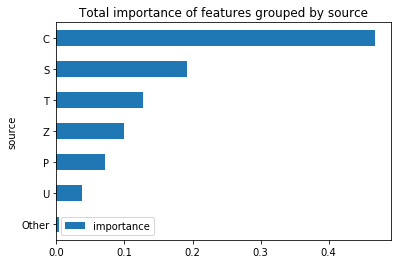

In [254]:
feature_importance_groups.groupby('source').sum().sort_values(by='importance').plot(kind = 'barh', title = "Total importance of features grouped by source")
plt.show()

Clearely our most important features are those we obtained by analysing the relative possition of units on the map. 

Sadly, these are also the features that we have no access to at any time before the end of a match due to the replay file's inaccurate unit tracking. We will discuss a manner of obtaining these features as an area for further study.

Our next step is to analize these features further and determine what forms of scaling, regularization and modelig would be most suitable.

### Feature Scaling

Several families of models and regularization techniques are sensitive to the scaling of our features, and it is abundantly clear that our 365 features encompass a wide range of scales.

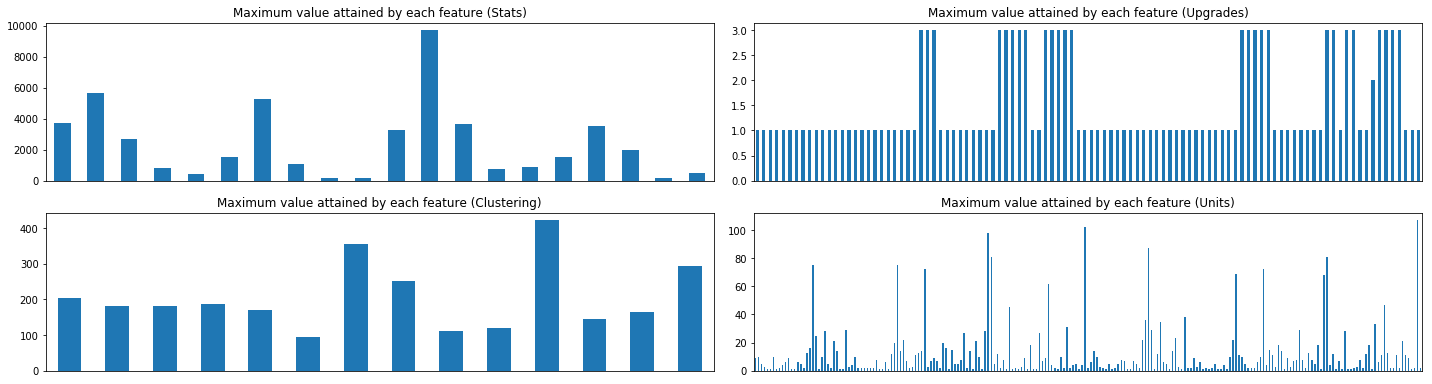

In [108]:
for i, features in enumerate(feature_sets):
    plt.subplot(3,2,i+1)
    ax = X[[col for col in X.columns if col[1] in features[1]]].max().plot(kind="bar", figsize = (20,8), title = "Maximum value attained by each feature ({})".format(features[0]))
    ax.get_xaxis().set_visible(False)
    
plt.tight_layout(h_pad=1)
plt.show()

Note that in this section we have absolutely no interest to see how a feature relates back to the ultimate winner of the game. 

We wish to consider only the intrinsic scale of the features, and due to the arbitraty nature of the assinment of player labels, we drop this information.

In [476]:
def unreference_players(dataframe):
    """This function drops references to playes 
    and returns a dataframe where features that 
    reference an aspect of each player are treated 
    as two instances of the same feature. More explicitly, 
    the features referingto player 2 are conactenated 
    under the ones refering to player 2"""
    pd.options.mode.chained_assignment = None  # default='warn'
    
    feats1 = [col for col in dataframe.columns if col[0] == '1']
    feats2 = [col for col in dataframe.columns if col[0] == '2']
    other = [col for col in dataframe.columns if col[0] not in ['1','2']]
    
    df1 = dataframe[feats1+other]
    df1.columns = [col.split('_',maxsplit=1)[1] if col in feats1 else col for col in feats1+other]
    
    df2 = dataframe[feats2+other]
    df2.columns = [col.split('_',maxsplit=1)[1] if col in feats2 else col for col in feats2+other]

    return pd.concat([df1,df2])

##### Scaling stats features

Perhaps our most agregious source of wildly varied scales are the features from player statistics.

In [477]:
stats_features = [col for col in X.columns if col[1] == 'S']
stats_data = unreference_players(X[stats_features])
stats_data.describe().T.sort_values(by = 'max')

,count,mean,std,min,25%,50%,75%,max
vespene_used_in_progress_economy,840.0,1.071429,12.639482,0.0,0.0,0.0,0.0,150.0
vespene_used_in_progress_technology,840.0,11.041667,42.974388,0.0,0.0,0.0,0.0,500.0
minerals_used_in_progress_economy,840.0,82.321429,147.526177,0.0,0.0,0.0,100.0,800.0
minerals_used_in_progress_technology,840.0,40.357143,105.428593,0.0,0.0,0.0,0.0,900.0
vespene_collection_rate,840.0,549.134524,340.512024,0.0,313.0,548.0,783.0,1523.0
vespene_used_in_progress_army,840.0,156.517857,197.891718,0.0,0.0,100.0,250.0,2000.0
minerals_used_in_progress_army,840.0,411.910714,384.764077,0.0,100.0,350.0,600.0,3650.0
minerals_collection_rate,840.0,1580.884524,759.067447,0.0,1007.0,1637.0,2183.0,3723.0
vespene_current,840.0,469.992857,489.115604,0.0,150.0,331.0,635.0,5278.0
minerals_current,840.0,450.259524,611.744703,0.0,118.0,290.0,575.0,9715.0


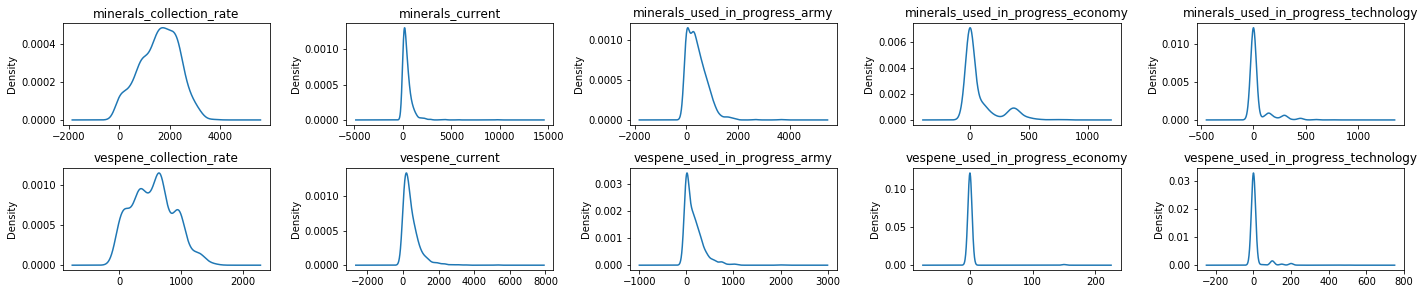

In [478]:
for i, col in enumerate(stats_data.columns): 
    plt.subplot(5,5,i+1)
    stats_data[col].plot(kind='kde', figsize = (20,10), title = col)
plt.tight_layout(w_pad= 1)
plt.show()

We clarely have a "Situation" with outliers... <right><img src="https://pics.me.me/houston-we-have-a-problem-27083503.png" style=" margin: 5px; height: 100px"></right>

The issue is even more notable when looking at a box plot.

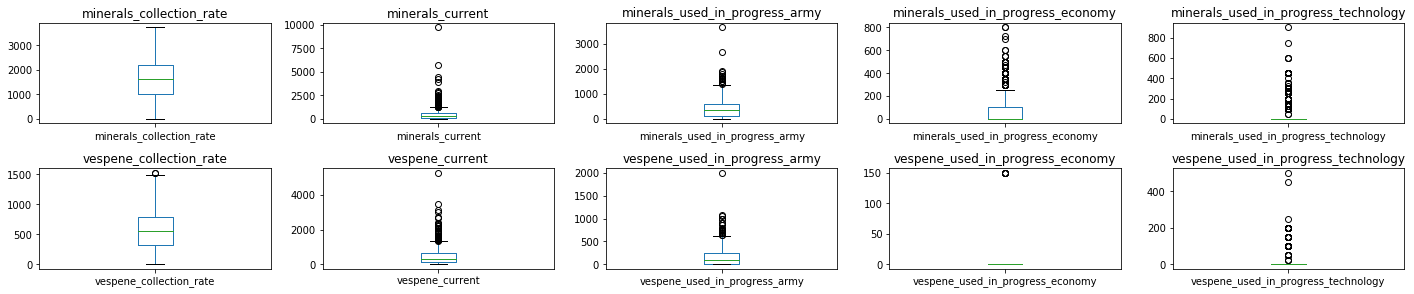

In [484]:
for i, col in enumerate(stats_data.columns): 
    plt.subplot(5,5,i+1)
    stats_data[col].plot(kind='box', figsize = (20,10), title = col)
plt.tight_layout(w_pad= 1)
plt.show()

It is our belief that - on these features in particular - extreme values are not particularely meaningful. They may in fact be rather misleading.

We are aware that this distorts the data in a non-linear way, making feature comparison much harder, but, in a way, the current amount of unspent currency or value of units/research underway is very much not comparable to other aspects of the game meassured in minerals/vespene.

We use a combination of the quantile transformer and the standard scaler to transform our features. This resultes in centered features and more eavenly spread out values.

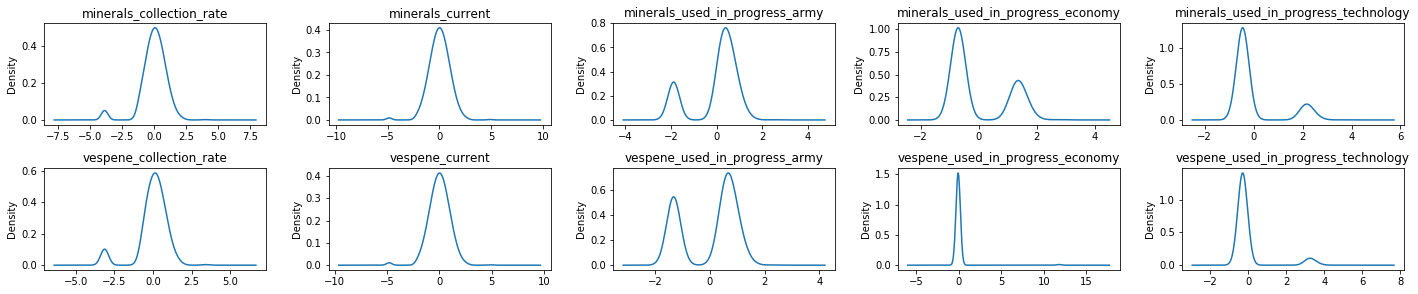

In [336]:
from sklearn.preprocessing import StandardScaler,QuantileTransformer

quantile_transformer = QuantileTransformer(output_distribution='normal')
standard_scaler = StandardScaler()

transfomed_stats_data_1 = pd.DataFrame(data = quantile_transformer.fit_transform(stats_data), 
                                       columns=stats_data.columns)

transfomed_stats_data_2 = pd.DataFrame(data = standard_scaler.fit_transform(transfomed_stats_data_1), 
                                       columns=stats_data.columns)

for i, col in enumerate(stats_data.columns): 
    plt.subplot(5,5,i+1)
    transfomed_stats_data_2[col].plot(kind='kde', figsize = (20,10), title = col)
plt.tight_layout(w_pad= 1)
plt.show()

In [359]:
def apply_scalers(X, scalers):
    """helper function that applies previously scalers in the given order"""
    data = X.copy()
    for scaler in scalers:
        data = scaler.transform(data)
    transformed_data = pd.DataFrame(data, columns=X.columns)
    return transformed_data

def scale_features_of_players(dataframe, scalers):
    """This function scales the features of players 
    using salers fitted on the features with players 
    treated as instances"""
    
    feats1 = [col for col in dataframe.columns if col[0] == '1']
    feats2 = [col for col in dataframe.columns if col[0] == '2']
    
    other = [col for col in dataframe.columns if col[0] not in ['1','2']]
    
    df1 = dataframe[feats1+other]
    df2 = dataframe[feats2+other]
    
    df1_tranformed = apply_scalers(df1, scalers)
    df2_tranformed = apply_scalers(df2, scalers)

    return pd.concat([df1_tranformed, df2_tranformed], axis=1)

In [364]:
transfomed_stats_data_of_players = scale_features_of_players(X[stats_features], [quantile_transformer, standard_scaler])

We can inspect the impact this scaling has had by fitting our logistic regression and random forest on the scaled features.

In [386]:
for model in models:
    print(name(model).ljust(23), assess_model(model, feature_matrix=transfomed_stats_data_of_players), 
          'Pre-scaling result:'.rjust(20), assess_model(model, feature_matrix=X[stats_features]))

LogisticRegression      0.838095238095  Pre-scaling result: 0.854761904762
RandomForestClassifier  0.857142857143  Pre-scaling result: 0.859523809524


We can see a marginal change to accuracy. It is interesting to note the deterioration in our linear model's predicitions, since - of the two models at hand - it was the only one with the capacity to consider the interaction between features (abeit, linear interactions). 

However, now that our features have been brought to a shared scale we can consider scale sensitive models and regularization. We will consider this in depth in a later section, but for now we can look at the result scaling has had on a SVC model with 

In [393]:
from sklearn.svm import LinearSVC
for model in models+[LinearSVC(random_state=2)]:
    print(name(model).ljust(23), assess_model(model, feature_matrix=transfomed_stats_data_of_players), 
          'Pre-scaling result:'.rjust(20), assess_model(model, feature_matrix=X[stats_features]))

LogisticRegression      0.838095238095  Pre-scaling result: 0.852380952381
RandomForestClassifier  0.857142857143  Pre-scaling result: 0.859523809524
LinearSVC               0.838095238095  Pre-scaling result: 0.678571428571


The results speak for themselves, but to be explicit: The 0.44% loss of accuracy on Logistic Regression has been well worth the 16% improvement on a previously unsuitable family of models.

### Scaling unit tally data

We now consider the issue of scaling unit tallies - our most inter connected set of features.

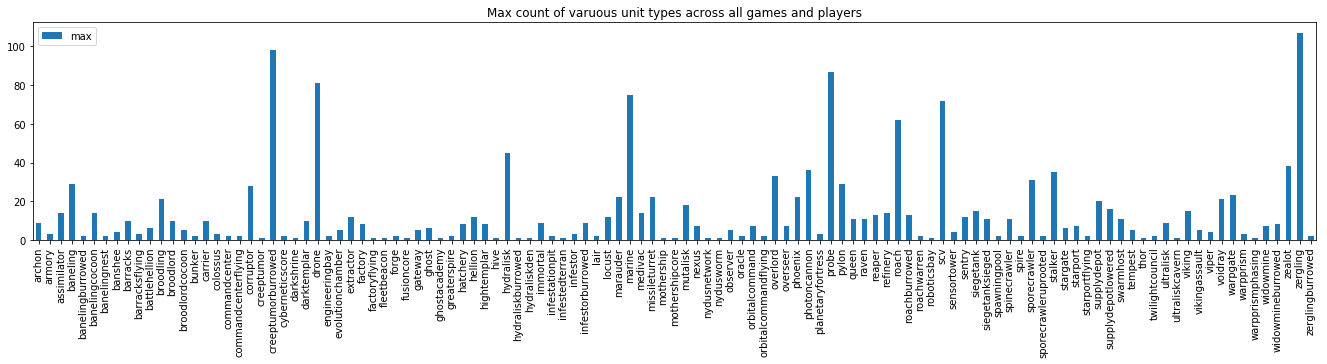

In [583]:
unit_tally_features = [col for col in X.columns if col[1] in ['T','P','Z']]
unit_tally_data = X[unit_tally_features]
ax = unreference_players(unit_tally_data).describe().T[['max']]\
    .plot(kind = 'bar', title = 'Max count of varuous unit types across all games and players', figsize = (23,4))
    
plt.show()

Clearerly not all of these features should be treated the same, and not all of these features should be grouped together, and not all of these features be distinguished from one another. We exemplify these situations as follows:

1) Zerglings (the unit with the highest observed count) are a mass produced cheap unit, weareas the Ultralisk is a late game powerhouse. 

<right><img src="https://terrancraft.files.wordpress.com/2015/12/zerg-army.jpg?w=1200" style=" margin: 5px; width: 200px"></right>



More agregious is the Mothership - a unit so powerfull that the game has a special rule stating that a Protoss player may have a maximim of 1 mothership.

<right><img src="http://vignette3.wikia.nocookie.net/starcraft/images/b/ba/Mothership_SC2_Art1.jpg/revision/latest?cb=20100115231423" style=" margin: 5px; width: 200px"></right>






2) The maximum number of observed archons and barracs may be similar, but these two "units" have no place being compared to one another. The former is an army unit and the latter a building.

3) The game handles unit "changes" through "UnitTypeChange" events. For example, these include a WiddowMine borrowing into the ground to become a borrowed widdow mine or viseversa. The two units have different properties (widdow mines, for example, are invisible to the enemy player when borrowed) but the cost to transition back and forth between these states is negligible or non-existant. 

It could be that a specific situation has led to an en-mass change of state, such as when Terran players lift their buildings (I should mention: their buildings can fly) to avoid an overwelming enemy army advancing on their possition. However, more generaly, these type changes are trivial, and their prescence is ultimately noice.

We buigin by introducing a further feature naming convention. 

    Unit tally featrures will be named using: 
    <player id><race initial><B for building, U for unit> + _ + <unit name>

In [556]:
buildings_mask = [col.split('_')[1] for col in unit_tally_features if unit_info_from_json[col.split('_')[1]].get('supply', 0) == 0]
units_mask = [col.split('_')[1] for col in unit_tally_features if col.split('_')[1] not in buildings_mask]

X_segregated_units = X.copy()

X_segregated_units.columns = [col.replace('_', 'U_') if col[3:] in units_mask 
             else col.replace('_','B_') if col[3:] in buildings_mask 
             else col for col in X.columns]

unit_tally_features_c = [col for col in X_segregated_units.columns if col[1:3] in ['TU','PU','ZU']]
building_tally_features_c = [col for col in X_segregated_units.columns if col[1:3] in ['TB','PB','ZB']]

In [584]:
X_segregated_units.head()

,1C_extreme_risk,1C_high_risk,1C_low_risk,1C_mid_risk,1C_military_power,1C_probable_casualties,1C_safe,1PU_archon,1PB_assimilator,1PU_carrier,...,2ZU_viper,2ZU_zergling,2ZU_zerglingburrowed,2_handicap,1_play_race_Protoss,1_play_race_Terran,1_play_race_Zerg,2_play_race_Protoss,2_play_race_Terran,2_play_race_Zerg
0,0.0,0.0,0.0,15.5,77.0,6.000000,215.5,0.0,0.0,0.0,...,0.0,0.0,0.0,100,0,1,0,0,1,0
1,0.0,0.0,0.0,0.0,2.0,0.000000,43.0,0.0,0.0,0.0,...,0.0,0.0,0.0,100,0,1,0,0,1,0
2,0.0,0.0,0.0,0.0,106.0,8.782957,231.0,0.0,0.0,0.0,...,0.0,0.0,0.0,100,0,1,0,0,1,0
3,0.0,0.0,0.0,0.0,79.5,0.000000,96.5,0.0,0.0,0.0,...,0.0,0.0,0.0,100,0,0,1,0,0,1
4,18.0,0.0,0.0,0.0,11.0,18.500000,97.0,0.0,0.0,0.0,...,0.0,0.0,0.0,100,0,0,1,0,0,1


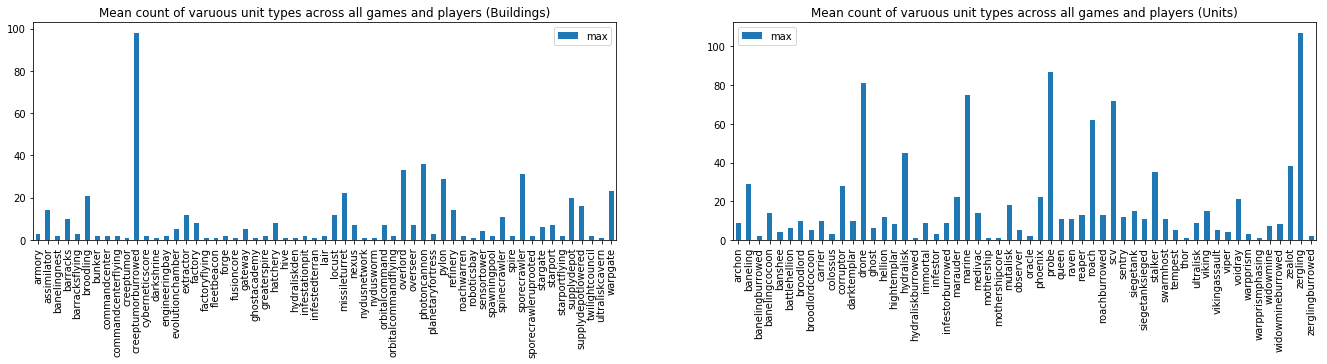

In [561]:
unit_tally_data = X_segregated_units[unit_tally_features_c]
building_tally_data = X_segregated_units[building_tally_features_c]

fig, axes = plt.subplots(ncols=2, nrows=1)
for i, data in enumerate([building_tally_data,unit_tally_data]):
    unreference_players(data).describe().T[['max']]\
    .plot(kind = 'bar', title = 'Max count of varuous unit types across all games and players ({})'.format(['Buildings','Units'][i]), figsize = (23,4), ax= axes[i])
    
plt.show()

To the unit tally data we scale the tally of units by the supply cost of the unit type.

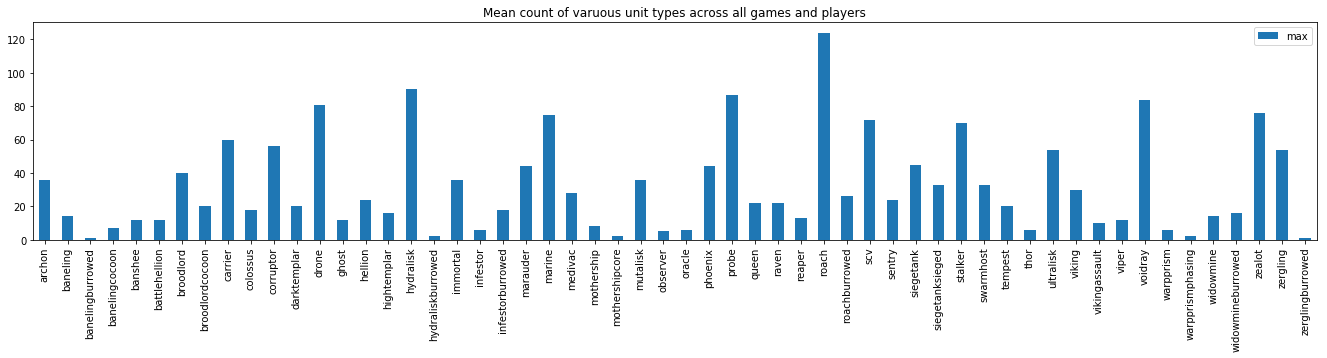

In [578]:
supply_scaled_unit_tally_data = unit_tally_data.apply(lambda x: x*unit_info_from_json[x.name.split('_')[1]].get('supply',0))

unreference_players(supply_scaled_unit_tally_data).describe().T[['max']]\
.plot(kind = 'bar', title = 'Mean count of varuous unit types across all games and players', figsize = (23,4))
plt.show()

In [585]:
for model in models+[LinearSVC(random_state=2,C = 10**6)]:
    print(name(model).ljust(23), assess_model(model, feature_matrix=supply_scaled_unit_tally_data), 
          'Pre-scaling result:'.rjust(20), assess_model(model, feature_matrix=unit_tally_data))

LogisticRegression      0.938095238095  Pre-scaling result: 0.935714285714
RandomForestClassifier  0.904761904762  Pre-scaling result: 0.907142857143
LinearSVC               0.938095238095  Pre-scaling result: 0.928571428571


We note the insignificant improvement of our accuracy on our pre-scaled features. However, in this case, our main goal in scaling the features was to obtain the deired behaviour once we seek to apply regilarization.

### EDA curiosities

It is, for example, interesting to look at the features from the clustering alalysis.

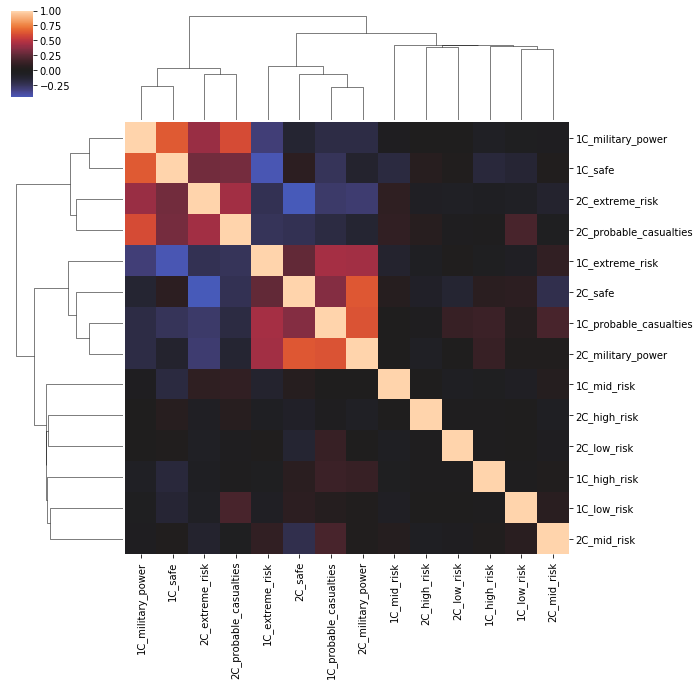

In [586]:
sns.clustermap(tabular_data[[col for col in tabular_data.columns if col[1] in ['C']]].corr(), center = 0)
plt.show()

This plot, for example, shows the interesting interplay beweeen the various situations. Player 1 is likely to be doing well when:
    
    1C_military_power
    1C_safe
    2C_extreme_risk
    2C_probable_casualties
    
are high (and vise-versa for player 2). It is nice to see that all these quatities are possitively correlated to each other, and negatively correlated to their dual for the other player (so that player 1 havig a high military power is negatively correlated with player 2 having an equally large army). This consistency of behaviour across our games is perhaps the best indicatior that these are the final moments of a match. 

## SECTION 4: Modeling

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

rfc = RandomForestClassifier(n_estimators=200, random_state=1)

rfc_report = pd.DataFrame(cross_validate(rfc, X,y, cv = 5)).mean()
rfc_report['model'] = 'default RandomForestClassifier'
rfc_report

In [ ]:
lr = LogisticRegression()
lr_report = pd.DataFrame(cross_validate(lr, X,y, cv = 5)).mean()
lr_report['model'] = 'default LogisticRegression'
lr_report

In [ ]:
svm_linear = SVC(kernel='linear')
svm_linear_report = pd.DataFrame(cross_validate(svm_linear, X,y, cv = 5)).mean()
svm_linear_report['model'] = 'default SVC'
svm_linear_report

In [ ]:
from sklearn.naive_bayes import MultinomialNB
mnnb = MultinomialNB()
mnnb_report = pd.DataFrame(cross_validate(mnnb, X,y, cv = 5)).mean()
mnnb_report['model'] = 'default MultinomialNB'
mnnb_report

In [ ]:
pd.DataFrame([mnnb_report, lr_report, svm_linear_report, rfc_report])

## more work is comming...

In [449]:
unit_lookup_table.sort_values(by='supply').tail(70)

,is_army,is_building,is_worker,minerals,name,supply,vespene
24,False,True,False,150,darkshrine,0.0,150
95,False,True,False,250,spire,0.0,200
94,False,True,False,150,spinecrawleruprooted,0.0,0
93,False,True,False,150,spinecrawler,0.0,0
28,False,True,False,125,engineeringbay,0.0,0
29,False,True,False,125,evolutionchamber,0.0,0
64,False,True,False,100,nydusworm,0.0,100
63,False,True,False,200,nydusnetwork,0.0,200
125,True,False,False,25,zerglingburrowed,0.5,0
124,True,False,False,25,zergling,0.5,0
